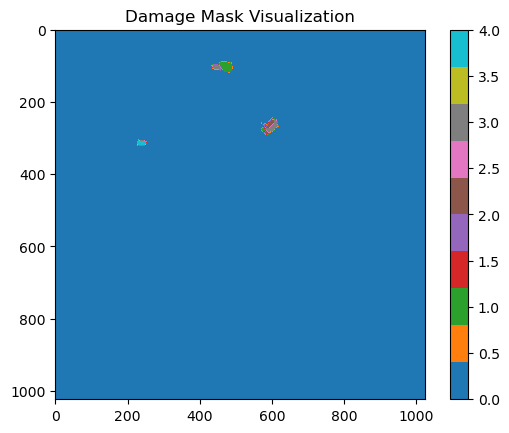

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

mask = np.array(Image.open("predicted_mask.png"))
plt.imshow(mask, cmap='tab10', vmin=0, vmax=4)
plt.colorbar()
plt.title("Damage Mask Visualization")
plt.show()

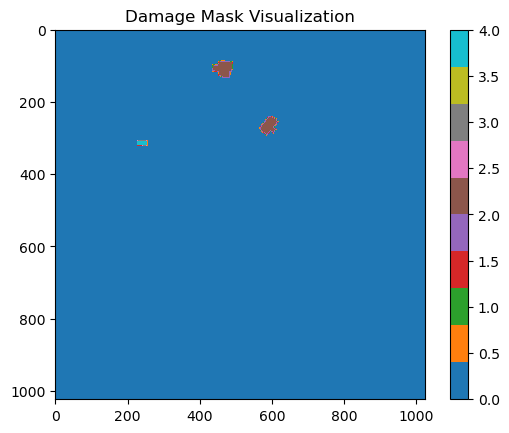

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

mask = np.array(Image.open("guatemala-volcano_00000003_mask.png"))
plt.imshow(mask, cmap='tab10', vmin=0, vmax=4)
plt.colorbar()
plt.title("Damage Mask Visualization")
plt.show()

Pre unique values: [0 1]
Post unique values: [0 1]


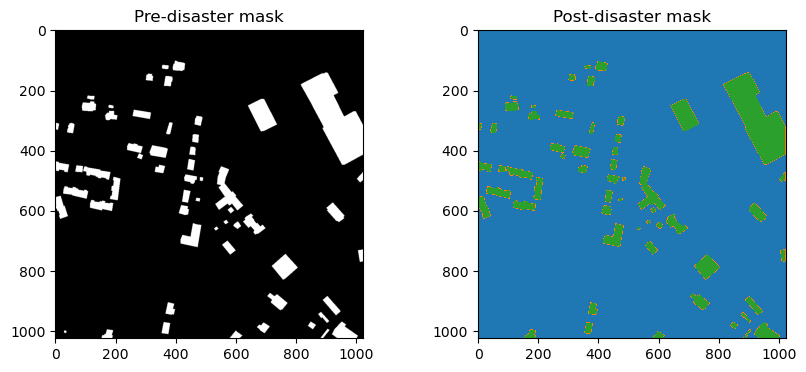

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

mask_pre = np.array(Image.open('train/targets/hurricane-florence_00000103_pre_disaster_target.png'))
mask_post = np.array(Image.open('train/targets/hurricane-florence_00000103_post_disaster_target.png'))

print("Pre unique values:", np.unique(mask_pre))
print("Post unique values:", np.unique(mask_post))


# visualize
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(mask_pre, cmap='gray')
plt.title("Pre-disaster mask")

plt.subplot(1,2,2)
plt.imshow(mask_post, cmap='tab10', vmin=0, vmax=4)
plt.title("Post-disaster mask")
plt.show()


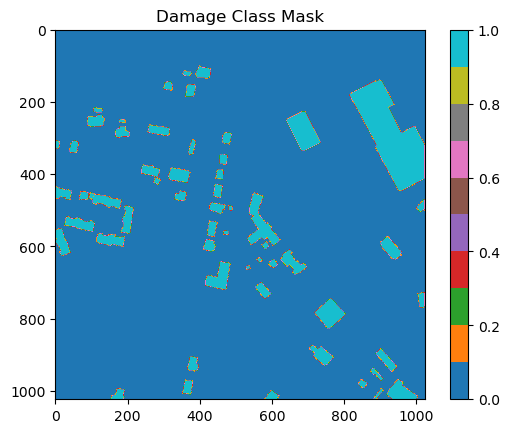

In [8]:
import cv2
import matplotlib.pyplot as plt

mask = cv2.imread("train_images_labels_targets/train/targets/hurricane-florence_00000103_post_disaster_target.png", 0)  # grayscale mask
plt.imshow(mask, cmap='tab10')  # or try 'viridis', 'nipy_spectral'
plt.colorbar()
plt.title("Damage Class Mask")
plt.show()

In [1]:
import json
import numpy as np
import cv2
from shapely import wkt
from shapely.geometry import Polygon, MultiPolygon
from pathlib import Path
from glob import glob
from tqdm import tqdm

# xView2 damage class mapping
DAMAGE_CLASSES = {
    "no-damage": 1,
    "minor-damage": 2,
    "major-damage": 3,
    "destroyed": 4,
}

# Get all post-disaster JSONs
post_json_paths = glob("train/labels/*_post_disaster.json")

# Total counts for each class
pixel_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

def create_damage_mask(post_json_path, image_size=(1024, 1024)):
    """
    Generates a 5-class damage classification mask.
    """
    with open(post_json_path, 'r') as f:
        data = json.load(f)

    mask = np.zeros(image_size, dtype=np.uint8)

    for feature in data["features"]["xy"]:
        props = feature["properties"]
        subtype = props.get("subtype", "no-damage")
        class_id = DAMAGE_CLASSES.get(subtype, 1)

        poly = wkt.loads(feature["wkt"])
        if isinstance(poly, Polygon):
            polygons = [poly]
        elif isinstance(poly, MultiPolygon):
            polygons = list(poly.geoms)
        else:
            continue

        for p in polygons:
            coords = np.array(p.exterior.coords).round().astype(np.int32)
            cv2.fillPoly(mask, [coords], class_id)

    return mask

# Iterate over all JSONs, create masks & count pixels
for post_json_path in tqdm(post_json_paths, desc="Counting pixels"):
    mask = create_damage_mask(post_json_path)

    unique, counts = np.unique(mask, return_counts=True)
    for u, c in zip(unique, counts):
        pixel_counts[int(u)] += int(c)

# Show results
print("\nPixel counts per class:")
for cls in range(5):
    print(f"Class {cls}: {pixel_counts[cls]:,} pixels")

total_pixels = sum(pixel_counts.values())
print(f"\nTotal pixels: {total_pixels:,}")
print("\nClass distribution (%):")
for cls in range(5):
    pct = 100 * pixel_counts[cls] / total_pixels
    print(f"Class {cls}: {pct:.2f}%")


Counting pixels: 100%|██████████| 2799/2799 [01:35<00:00, 29.23it/s]


Pixel counts per class:
Class 0: 2,759,473,248 pixels
Class 1: 129,895,011 pixels
Class 2: 15,945,872 pixels
Class 3: 20,134,232 pixels
Class 4: 9,515,861 pixels

Total pixels: 2,934,964,224

Class distribution (%):
Class 0: 94.02%
Class 1: 4.43%
Class 2: 0.54%
Class 3: 0.69%
Class 4: 0.32%


### OBSERVATIONS:
- Severe imbalance of classes: ~94% of pixels are background pixels which is reasonable due to 1024 x 1024 size. Damage classes 2,3,4 together only make ~1.5%. No damage pixels make ~4.5%

- This means that CrossEntropy or Dice Loss wil be dominated by the background and no-damage pixels. This means that predicting 1 or 0 for every pixel blindly will give a good pixel accuracy
For this, we can down-weight easy samples, focusing the loss on hard, misclassified pixels.

- We can't perfectly estimate class weights. Hence, we can go with Focal Loss instead of CE.

- There is another option as well, we can do patch sampling, either random or deterministic

### DIFFERENT MODEL CONFIGS 

- FIRST MODEL: DICE+CE, No ImageNet Normalization, 20 epochs:

Epoch 20/20 | Loss: 0.1547 | Acc: 0.9819 | mIoU: 0.7313

Bad performance on Test set, tends to predict between class 0 and 1

- SECOND MODEL: DICE+Focal (alpha:0.25, gamma:0.20), With ImageNet Normalization, 20 epochs:

Epoch 20/20 | Loss: 0.1292 | Acc: 0.9781 | mIoU: 0.6699
Per-class IoU - Class1: 0.4362, Class2: 0.1461, Class3: 0.1840, Class4: 0.1702

Better performance interms of segmentation, but still there is a lot of room for improvement interms of classification and a bit of segmentation.
